# Module 8 Assignment 1: Dogs vs. Cats Redux: Kernel Edition

**Reed Ballesteros**

**MSDS-422**

**5/22/2022**

**Instructor: Prof. Noah Gift**

# Dogs vs. Cats Redux: Kernel Edition 
https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition

## Background Materials
The Dogs vs. Cats Redux:  Kernel Edition (Links to an external site.) on Kaggle.com is a foundational CNN problem. This week, you will compete in this competition and submit scores to Kaggle.com.

RECOMMENDATION: the data set here is large, so you might consider conducting exploratory data analysis and building initial models on a smaller subsample prior to applying it to the full dataset.  Eventually, you will need to build your models on the entirety, though.

### Management/Research Question
In layman’s terms, what is the management/research question of interest, and why would anyone care?  

### Requirements
- Conduct your analysis using a cross-validation design.
- Conduct EDA.
- Build at least three CNN models based on hyperparameter tuning.
- Evaluate goodness of fit metrics.
- Build ROC and Precision / Recall graphs.
- Once you have your best-performing models, classify the test data and submit it to Kaggle. Provide your Kaggle.com user name - and screen snapshots of your scores.
- Discuss your model’s performance.

### Python Programming
All programming will be done in Python.

**Libraries to be loaded:**

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import seaborn as sns
import sys

from matplotlib.image import imread
from os import makedirs
from os import listdir
from shutil import copyfile
from tensorflow.config import list_physical_devices
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.python.client import device_lib
from torch import cuda

**Install and configure NVidia Cuda to enbable TensoFlow to use the GPU installed in this system to help speed up training and processing ML model predictions.**

**The commands below confirm that NVidia Cuda and that a GPU is available.**

In [2]:
cuda.is_available()

True

In [3]:
list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13417253874774686276
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5769199616
locality {
  bus_id: 1
  links {
  }
}
incarnation: 373094674904710902
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


## INGEST

**Let's reorganize the training data to be split into training and validation sets, with each set containing directories of categorized dog and cat images.**

In [ ]:
# reorganize images in train into categorized training and validation set
dataset_home = 'dogs_v_cats/'
subdirs = ['train/', 'validation/']
for subdir in subdirs:
    # create label subdirectories
    labeldirs = ['dogs/', 'cats/']
    for labldir in labeldirs:
        newdir = dataset_home + subdir + labldir
        makedirs(newdir, exist_ok=True)
# seed random number generator
random.seed(43)
# 80/20 training/validation ratio for training data
val_ratio = 0.2
# copy training dataset images into new directories
src_directory = 'train/'
for file in listdir(src_directory):
    src = src_directory + '/' + file
    dst_dir = 'train/'
    if random.random() < val_ratio:
        dst_dir = 'validation/'
    if file.startswith('cat'):
        dst = dataset_home + dst_dir + 'cats/'  + file
        copyfile(src, dst)
    elif file.startswith('dog'):
        dst = dataset_home + dst_dir + 'dogs/'  + file
        copyfile(src, dst)

## EDA

**Let's plot some of the dog and cat image data from the original training directory.**

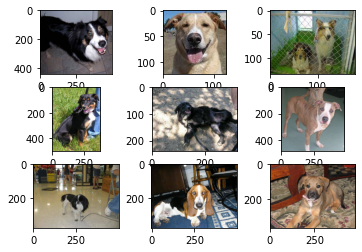

In [5]:
# plot random dog photos from original training dataset
from matplotlib import pyplot
from matplotlib.image import imread
folder = './train/'
for i in range(9):
    rand_img = random.randint(0, 12499)
    pyplot.subplot(330 + 1 + i)
    filename = folder + 'dog.' + str(rand_img) + '.jpg'
    image = imread(filename)
    pyplot.imshow(image)
pyplot.show()

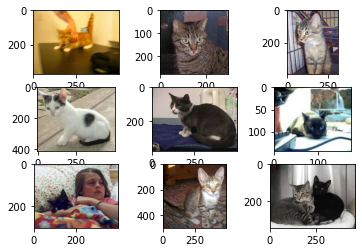

In [6]:
# plot random cat photos from original training dataset
from matplotlib import pyplot
from matplotlib.image import imread
# define location of dataset
folder = './train/'
# plot first few images
for i in range(9):
    rand_img = random.randint(0, 12499)
    pyplot.subplot(330 + 1 + i)
    filename = folder + 'cat.' + str(i) + '.jpg'
    image = imread(filename)
    pyplot.imshow(image)
pyplot.show()

## MODELLING

In [ ]:
# display diagnostics
def display_diagnostics(history):
    # loss
    pyplot.subplot(211)
    pyplot.title('Cross Entropy Loss')
    pyplot.plot(history.history['loss'], color='blue', label='train')
    pyplot.plot(history.history['val_loss'], color='orange', label='test')
    # plot accuracy
    pyplot.subplot(212)
    pyplot.title('Classification Accuracy')
    pyplot.plot(history.history['accuracy'], color='blue', label='train')
    pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
    pyplot.show()

In [129]:
def load_image(filename):
    img = load_img(filename, target_size=(224, 224))
    img = img_to_array(img)
    img = img.reshape(1, 224, 224, 3)
    img = img.astype('float32')
    img = img - [123.68, 116.779, 103.939]
    return img

In [148]:
# neural network training configurations
num_epochs = 5
learning_rate=0.001

In [149]:
# create cnn model
def create_cnn_model():
    # load base CNN architecture
    base_model = VGG16(include_top=False, input_shape=(224, 224, 3))
#    base_model = VGG19(include_top=False, input_shape=(224, 224, 3))
#    base_model = ResNet50(include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False
    for layer in base_model.layers:
        layer.trainable = False
    # add the remaining classifer neural network layers
    flatten_layer = Flatten()
    dense_layer_1 = Dense(128, activation='relu', kernel_initializer='he_uniform')
    prediction_layer = Dense(1, activation='sigmoid')
    cnn_model = Sequential([
        base_model,
        flatten_layer,
        dense_layer_1,
        prediction_layer
    ])
    opt = SGD(learning_rate=learning_rate, momentum=0.9)
    cnn_model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return cnn_model

In [150]:
# train model
def train_model():
    training_model = create_cnn_model()
    imgDataGenerator = ImageDataGenerator(featurewise_center=True)
    imgDataGenerator.mean = [123.68, 116.779, 103.939]
    training_set = imgDataGenerator.flow_from_directory('./dogs_v_cats/train/',
                        class_mode='binary', batch_size=64, target_size=(224, 224))
    validation_set = imgDataGenerator.flow_from_directory('./dogs_v_cats/validation/',
                        class_mode='binary', batch_size=64, target_size=(224, 224))
    # fit model and evaluate accuracy with each epoch
    history = training_model.fit(training_set, steps_per_epoch=len(training_set), 
                        validation_data=validation_set, validation_steps=len(validation_set), 
                        epochs=num_epochs, verbose=1)
    return training_model, history

In [151]:
model, history = train_model()

Found 19999 images belonging to 2 classes.
Found 5001 images belonging to 2 classes.
Epoch 1/5
313/313 [==============================] - 81s 255ms/step - loss: 0.2033 - accuracy: 0.9647 - val_loss: 0.0685 - val_accuracy: 0.9726
Epoch 2/5
313/313 [==============================] - 82s 261ms/step - loss: 0.0241 - accuracy: 0.9918 - val_loss: 0.0631 - val_accuracy: 0.9750
Epoch 3/5
313/313 [==============================] - 80s 255ms/step - loss: 0.0059 - accuracy: 0.9989 - val_loss: 0.0714 - val_accuracy: 0.9762
Epoch 4/5
313/313 [==============================] - 80s 255ms/step - loss: 0.0017 - accuracy: 0.9998 - val_loss: 0.0779 - val_accuracy: 0.9764
Epoch 5/5
313/313 [==============================] - 82s 262ms/step - loss: 9.2725e-04 - accuracy: 0.9999 - val_loss: 0.0807 - val_accuracy: 0.9766


In [152]:
model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_17 (Flatten)        (None, 25088)             0         
                                                                 
 dense_35 (Dense)            (None, 128)               3211392   
                                                                 
 dense_36 (Dense)            (None, 1)                 129       
                                                                 
Total params: 17,926,209
Trainable params: 3,211,521
Non-trainable params: 14,714,688
_________________________________________________________________


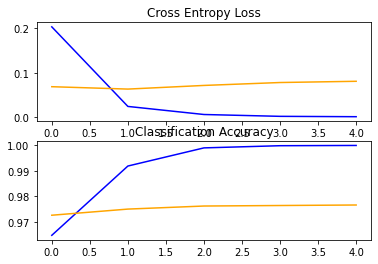

In [153]:
display_diagnostics(history)

In [154]:
model_filename = 'model_vgg16.h5'
#model_filename = 'model_vgg19.h5'
#model_filename = 'model_resnet50.h5'
model.save(model_filename)

In [155]:
final_model = load_model(model_filename)

In [156]:
final_model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_17 (Flatten)        (None, 25088)             0         
                                                                 
 dense_35 (Dense)            (None, 128)               3211392   
                                                                 
 dense_36 (Dense)            (None, 1)                 129       
                                                                 
Total params: 17,926,209
Trainable params: 3,211,521
Non-trainable params: 14,714,688
_________________________________________________________________


**Let's pick a random sample of 25 images from the test set and see how the trained model works on it.**

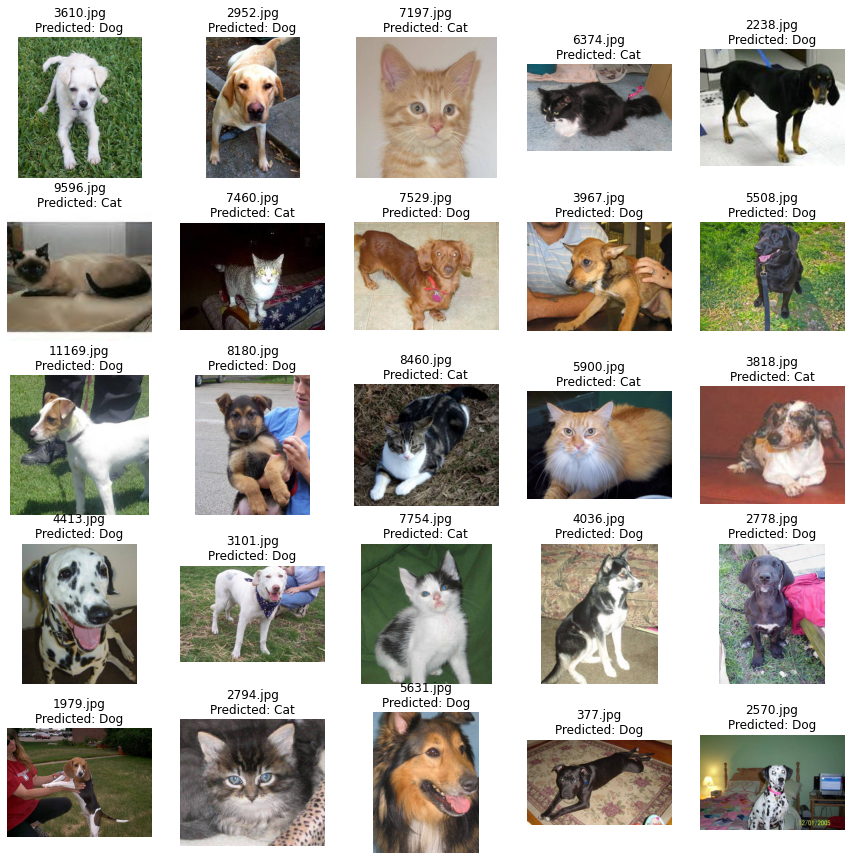

In [157]:
f, ax = plt.subplots(5,5, figsize=(15,15))

for i in range(0, 25):
    rand_img = random.randint(0, 12499)
    file_name = './test/' + str(rand_img) + '.jpg'
    file_name_stripped = str(rand_img) + '.jpg'
    img = load_image(file_name)
    result = final_model.predict(img, verbose=0)
    isDog = result[0][0].astype('int')
    if isDog: 
        str_predicted='Dog'
    else: 
        str_predicted='Cat'
    ax[i//5, i%5].imshow(load_img(file_name))
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_title(file_name_stripped + "\nPredicted: {}".format(str_predicted))    
plt.show()

### SUBMISSION

In [158]:
ids = []
labels = []
directory = 'test'

count = 0
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    if os.path.isfile(f):
        img = load_image(f)
        result = final_model.predict(img, verbose=0)
        label = result[0][0]
        filename_stripped = filename.replace('.jpg', '')
        this_id = int(filename_stripped)
        ids.append(this_id)
        labels.append(label)
        count+=1
        if (count%500==0):
            print(str(count) + ' completed')

print('DONE')

500 completed
1000 completed
1500 completed
2000 completed
2500 completed
3000 completed
3500 completed
4000 completed
4500 completed
5000 completed
5500 completed
6000 completed
6500 completed
7000 completed
7500 completed
8000 completed
8500 completed
9000 completed
9500 completed
10000 completed
10500 completed
11000 completed
11500 completed
12000 completed
12500 completed
DONE


In [159]:
# format result set into acceptable Kaggle submission by slightly padding 0 results and clipping 1 results
labels_edit = np.clip(labels, 0.025, 0.975)

In [160]:
submission = pd.DataFrame({'id':ids , 'label':labels_edit})
submission.head()
submission.to_csv("submission.csv", index=False)

From my Kaggle submissions below, by best score was 0.09639 after clipping my resulting labels data and using the VGG16 convolution neural network (CNN) archtiecture.

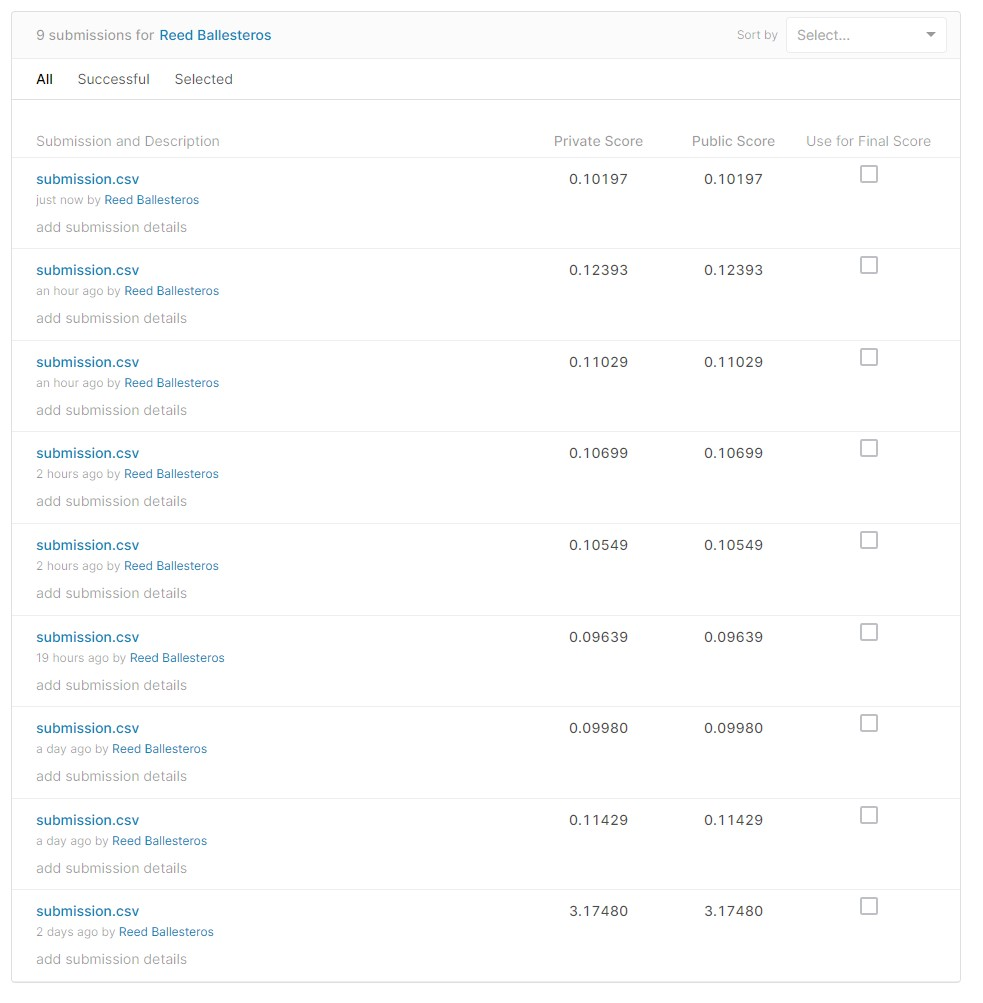

## CONCLUSION